In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score,mean_squared_error



dtrain = pd.read_csv(r'D:\Asha\Imp\Python\Big_Mart_Sales_Data\Train_UWu5bXk.csv')
dtest = pd.read_csv(r'D:\Asha\Imp\Python\Big_Mart_Sales_Data\Test_u94Q5KV.csv')

# checking the shape of the data
dtrain.shape , dtest.shape

# Check basic info about the data
#train.info()  , test.info()
# Item_Outlet_Sales is the outcome variable which is not present int test dataset. 

# Combining Train & Test
dtrain['source'] = 'Train'
dtest['source'] = 'Test'
train = pd.concat([dtrain,dtest],ignore_index=True,sort=True)
# re-oredering the columns as before
cols = dtrain.columns
train = train[cols]

In [2]:
# Variables Analysis
train.isnull().sum() 
# Item_Weight(2439)  & Outlet_Size  have null values which need to be treated.

# Item Identifier is a unique ID. Getting first 2 letters to make a generic category
train['Item_Identifier'] = train['Item_Identifier'].apply(lambda x:x[0:2])
train['Item_Identifier'] =train['Item_Identifier'].map({'FD':1,'DR':2,'NC':3})

# Item_Weight has missing values. Getting the median value to fill the null values
train.Item_Weight = train.Item_Weight.fillna(train.Item_Weight.median())

# Item_Fat_Content has misspelled labels. Correcting the lebels.
train.Item_Fat_Content.groupby(train.Item_Fat_Content).count()
train.Item_Fat_Content.replace(['LF','low fat','reg'],['Low Fat','Low Fat','Regular'],inplace=True)
train.Item_Fat_Content = train.Item_Fat_Content.map({'Low Fat':0,'Regular':1}).astype(int)


# Item_Visibility has zero value(879 records). Filling 0 with median
train.Item_Visibility.groupby(train.Item_Visibility).count()
train.Item_Visibility = train.Item_Visibility.apply(lambda x: train.Item_Visibility.median() if x == 0 else x)

# Item_Type has 16 unique values.
train.Item_Type.groupby(train.Item_Type).count().sort_values()

#Item_MRP - No 0 values. Min value is 31.29 and max is 266.8884
train.Item_MRP.describe()

# Outlet_Establishment_Year . Except 1985 & 1998, approximately similar count of outlets for all years. Adding outlet Age column
train.Outlet_Establishment_Year.groupby(train.Outlet_Establishment_Year).count()
train['Outlet_Age'] = train.Outlet_Establishment_Year.apply(lambda x: 2018 - x)
train.drop('Outlet_Establishment_Year',1,inplace=True)

# Outlet_Identifier -converting to int
train['Outlet_Identifier'] = train['Outlet_Identifier'].apply(lambda x:x[-2:]).astype(int)

# Outlet_Size has missing values (4016 records). Medium is the most frequent value. So,filling missing values with it.
train.Outlet_Size.fillna('Medium',inplace=True)
train['Outlet_Size'] = train['Outlet_Size'].map({'High':3,'Medium':2,'Small':1}).astype(int)

# Outlet_Location_Type & Outlet_Type - No missing values
train.Outlet_Location_Type.groupby(train.Outlet_Location_Type).count()
train['Outlet_Location_Type'] = train['Outlet_Location_Type'].map({'Tier 1':1, 'Tier 3':3, 'Tier 2':2}).astype(int)
train.Outlet_Type.groupby(train.Outlet_Type).count()
train['Outlet_Type'] = train['Outlet_Type'].map({'Supermarket Type1':1, 'Supermarket Type2':2, 'Grocery Store':4, 'Supermarket Type3':3}).astype(int)

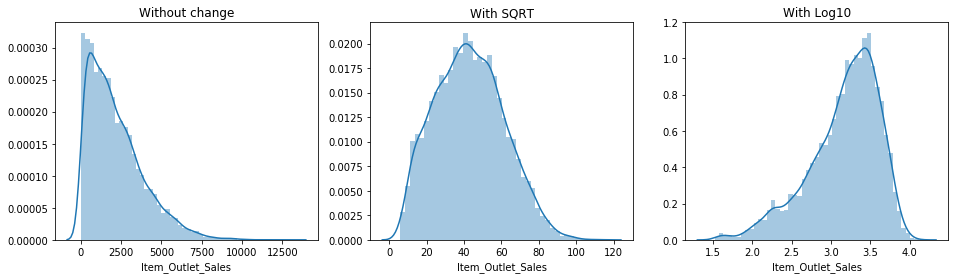

In [3]:
# Now, taking train data set for outcome variable analysis as test data set dosen't have it
v_train = train.loc[train.source == 'Train']
v_train.drop('source',1,inplace=True)
# Item_Outlet_Sales has right-skewed distribution. Taking sqrt & log10 to get a better distribution
s_train = v_train.Item_Outlet_Sales.apply(lambda x: np.sqrt(x))
l_train = v_train.Item_Outlet_Sales.apply(lambda x: np.log10(x))
plt.figure(figsize =(16,4))
plt.subplot(131)
plt.title('Without change')
sns.distplot(v_train.Item_Outlet_Sales)
plt.subplot(132)
plt.title('With SQRT')
sns.distplot(s_train)
plt.subplot(133)
plt.title('With Log10')
sns.distplot(l_train)
# Taking SQRT provides better distribution . I'll model for all 3 options and check which gives better result.

In [4]:
# Visualizing relationship between outlet sales and numerical variables with corr()
v_train['Item_Outlet_Sales'] = v_train['Item_Outlet_Sales'].apply(lambda x: np.log10(x))
v_train.corr()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age
Item_Identifier,1.000000,0.027818,-0.416064,-0.073282,-0.014283,-0.005350,0.003418,0.003993,0.003156,-0.016254,0.000851
Item_Weight,0.027818,1.000000,-0.021092,-0.018773,0.024951,-0.005421,0.010536,0.001958,-0.013128,0.009714,-0.007739
Item_Fat_Content,-0.416064,-0.021092,1.000000,0.049794,0.006063,0.000477,0.000622,-0.001598,-0.001967,0.012280,-0.003151
Item_Visibility,-0.073282,-0.018773,0.049794,1.000000,-0.004537,-0.118184,-0.072313,-0.028119,0.234340,-0.202260,0.078273
Item_MRP,-0.014283,0.024951,0.006063,-0.004537,1.000000,0.004061,-0.006059,0.000232,-0.006671,0.509671,-0.005020
Outlet_Identifier,-0.005350,-0.005421,0.000477,-0.118184,0.004061,1.000000,-0.433151,-0.692148,-0.479863,0.268377,-0.141465
Outlet_Size,0.003418,0.010536,0.000622,-0.072313,-0.006059,-0.433151,1.000000,0.614311,-0.098807,0.123001,0.193389
Outlet_Location_Type,0.003993,0.001958,-0.001598,-0.028119,0.000232,-0.692148,0.614311,1.000000,0.290939,0.058978,0.089216
Outlet_Type,0.003156,-0.013128,-0.001967,0.234340,-0.006671,-0.479863,-0.098807,0.290939,1.000000,-0.454345,0.433070
Item_Outlet_Sales,-0.016254,0.009714,0.012280,-0.202260,0.509671,0.268377,0.123001,0.058978,-0.454345,1.000000,-0.077240


In [5]:
# Model 1: Linear Regression with all features and outcome variable without applying SQRT/Log10
# Splitting the data set into Train & Test 
dtrain = train.loc[train['source'] == 'Train']
dtest =  train.loc[train['source'] == 'Test']

dtrain.drop('source',1,inplace=True)
dtest.drop('source',1,inplace=True)

dtrain = pd.get_dummies(dtrain)
dtest = pd.get_dummies(dtest)


X = dtrain.loc[:,dtrain.columns != 'Item_Outlet_Sales']
Y = dtrain.loc[:,dtrain.columns == 'Item_Outlet_Sales']

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.3 ,random_state=7)


alg = LinearRegression()
alg.fit(x_train,y_train)
predicted = alg.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, predicted))
rmse , alg.score(x_test,y_test) , alg.score(x_train,y_train)

(1264.1678584913627, 0.457368899037072, 0.4679946095469816)

In [6]:
# Model 2: Linear Regression with all features and taking SQRT of outcome variable normal
# Splitting the data set into Train & Test 

strain = pd.get_dummies(dtrain)
stest = pd.get_dummies(dtest)

strain['Item_Outlet_Sales'] = strain['Item_Outlet_Sales'].apply(lambda x: np.sqrt(x))
stest['Item_Outlet_Sales'] = stest['Item_Outlet_Sales'].apply(lambda x: np.sqrt(x))

X = strain.loc[:,strain.columns != 'Item_Outlet_Sales']
Y = strain.loc[:,strain.columns == 'Item_Outlet_Sales']

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.3 ,random_state=7)


alg = LinearRegression()
alg.fit(x_train,y_train)
spredicted = alg.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, spredicted))
rmse , alg.score(x_test,y_test) , alg.score(x_train,y_train)

(12.49088430125967, 0.5315255176070193, 0.542425060480728)

In [7]:
# Model 3: Linear Regression with all features and taking Log10 of outcome variable normal
# Splitting the data set into Train & Test 
ltrain = pd.get_dummies(dtrain)
ltest = pd.get_dummies(dtest)

ltrain['Item_Outlet_Sales'] = ltrain['Item_Outlet_Sales'].apply(lambda x: np.log10(x))
ltest['Item_Outlet_Sales'] = ltest['Item_Outlet_Sales'].apply(lambda x: np.log10(x))

X = ltrain.loc[:,ltrain.columns != 'Item_Outlet_Sales']
Y = ltrain.loc[:,ltrain.columns == 'Item_Outlet_Sales']

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size = 0.3 ,random_state=7)

# Linear Regression
alg = LinearRegression()
alg.fit(x_train,y_train)
lpredicted = alg.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, lpredicted))
rmse , alg.score(x_test,y_test) , alg.score(x_train,y_train)
# (0.28502369777497627, 0.5769583879219086, 0.5954012992719978)

# Decision Tree ( 4th Model)
alg = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
alg.fit(x_train,y_train)
l1predicted = alg.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, l1predicted))
rmse , alg.score(x_test,y_test) , alg.score(x_train,y_train)

# (0.2347777423091454, 0.712964910162193, 0.7500204814651195)


(0.23477774230914544, 0.7129649101621929, 0.7500204814651195)

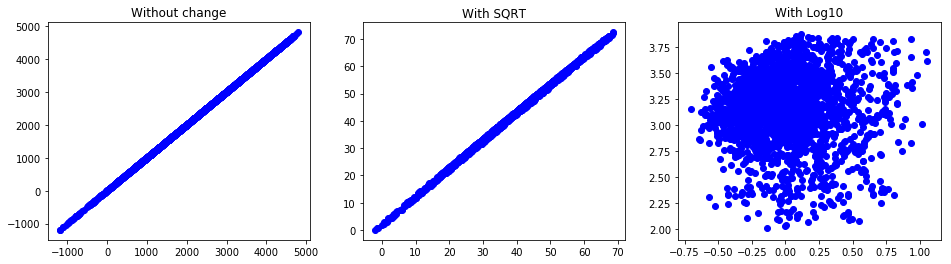

In [8]:
# Residual Charts
plt.figure(figsize =(16,4))
plt.subplot(131)
plt.title('Without change')
x_plot = plt.scatter((predicted - y_test),predicted, c='b') 

plt.subplot(132)
plt.title('With SQRT')
x_plot = plt.scatter((spredicted - y_test),spredicted,  c='b') 

plt.subplot(133)
plt.title('With Log10')
x_plot = plt.scatter((lpredicted - y_test),lpredicted,  c='b') 


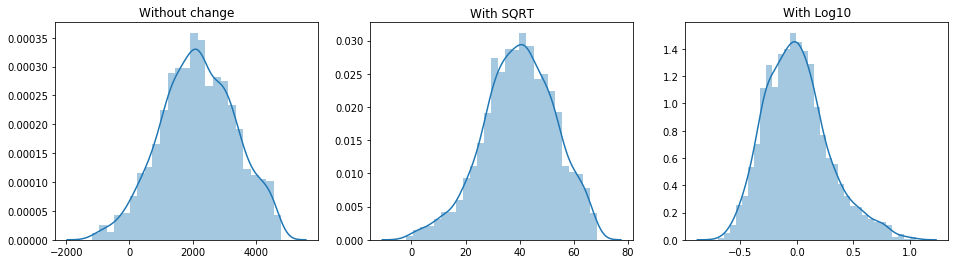

In [11]:
plt.figure(figsize =(16,4))
plt.subplot(131)
plt.title('Without change')
sns.distplot(predicted - y_test)

plt.subplot(132)
plt.title('With SQRT')
sns.distplot(spredicted - y_test)

plt.subplot(133)
plt.title('With Log10')
sns.distplot(lpredicted - y_test)

In [ ]:
# Conclusion : Linear Regression can be used on this data set with log target column.